## Verificacao de Algoritmos

Neste notebook sera verificado o uso do algoritmo Word2Vec e Doc2Vec juntamente com o algoritmo de clusterizacao Spectral Clustering para um "treinamento" nao supervisionado.

In [65]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [66]:
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_similarity, 
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import SpectralClustering

from gensim.models import Word2Vec, Doc2Vec

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

In [67]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

### Unsupervised Learning : Word2Vec +  Spectral Clustering

In [68]:
w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")
print(f"Palavras no vocab: {len(list(w2v.wv.vocab))}")

# from gensim.models import KeyedVectors
# model = KeyedVectors.load_word2vec_format(f"{os.getcwd()}/../ai/models/skip_s300.txt")

Palavras no vocab: 210654


In [69]:
n_textos = []
for texto in textos:
    doc = []
    for palavra in texto[0].split():
        try:
            doc.append(w2v.wv[palavra])
        except:
            # print(palavra)
            # doc.append(np.ones((150, )))
            pass
    doc = np.asarray(doc)
    doc = np.mean(doc, axis=0)
    n_textos.append(doc)
n_textos = np.asarray(n_textos)

In [70]:
validacoes = []

X = n_textos
y = textos[:, 1].astype(np.int).ravel()

for metric in (
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    polynomial_kernel,
    rbf_kernel
):
    for assign_labels in ["discretize", "kmeans"]:
        clustering = SpectralClustering(
            n_clusters=2,
            eigen_solver="amg",
            assign_labels=assign_labels,
            affinity="precomputed_nearest_neighbors",
            random_state=0,
            n_jobs=-1
        ).fit(metric(X))

        pred = clustering.labels_
        acc = round(accuracy_score(pred, y) * 100, 2)
        f1 = round(f1_score(pred, y) * 100, 2)
        vm = round(v_measure_score(y, pred), 2)
        silhouette = None
        try:
            silhouette = silhouette_score(metric(X), pred, metric="precomputed")
        except:
            pass
        validacoes.append((
            metric.__name__,
            assign_labels,
            acc, 
            f1,
            vm,
            silhouette
        ))

In [74]:
columns = ["Metric", "AssignLabels", "Accuracy", "F1", "V-Measure", "Silhouette"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Silhouette", "Metric"], ascending=False)
df.reset_index().head(25)

,Metric,AssignLabels,Accuracy,F1,V-Measure,Silhouette
3,laplacian_kernel,kmeans,37.64,49.65,0.02,NaN
1,cosine_distances,kmeans,66.28,45.51,0.05,0.221881
10,rbf_kernel,discretize,35.92,43.45,0.03,NaN
5,euclidean_distances,kmeans,33.05,41.51,0.06,0.155404
0,cosine_distances,discretize,33.62,39.58,0.06,0.183314
6,sigmoid_kernel,discretize,54.50,38.23,0.00,NaN
7,sigmoid_kernel,kmeans,54.50,38.23,0.00,NaN
8,polynomial_kernel,discretize,54.50,38.23,0.00,NaN
9,polynomial_kernel,kmeans,54.50,38.23,0.00,NaN
4,euclidean_distances,discretize,32.95,37.39,0.06,0.122168


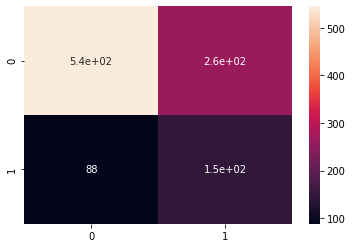

In [75]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="kmeans",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(cosine_distances(X))

pred = clustering.labels_
df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()

### Unsupervised Learning : Doc2Vec +  Spectral Clustering

In [76]:
d2v = Doc2Vec.load(f"{os.getcwd()}/../ai/models/d2v.model")

In [117]:
n_textos = []
for texto in textos:
    doc_vec = d2v.infer_vector(texto[0].split())
    n_textos.append(doc_vec)
n_textos = np.asarray(n_textos)

In [118]:
validacoes = []

X = n_textos
y = textos[:, 1].astype(np.int).ravel()

for metric in (
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    rbf_kernel
):
    for assign_labels in ["discretize", "kmeans"]:
        clustering = SpectralClustering(
            n_clusters=2,
            eigen_solver="amg",
            assign_labels=assign_labels,
            affinity="precomputed_nearest_neighbors",
            random_state=0,
            n_jobs=-1
        ).fit(metric(X))

        pred = clustering.labels_
        acc = round(accuracy_score(pred, y) * 100, 2)
        f1 = round(f1_score(pred, y) * 100, 2)
        vm = round(v_measure_score(y, pred), 2)
        silhouette = None
        try:
            silhouette = silhouette_score(metric(X), pred, metric="precomputed")
        except:
            pass
        validacoes.append((
            metric.__name__,
            assign_labels,
            acc, 
            f1,
            vm,
            silhouette
        ))

In [122]:
columns = ["Metric", "AssignLabels", "Accuracy", "F1", "V-Measure", "Silhouette"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Silhouette", "Metric"], ascending=False)
df.reset_index().head(25)

,index,Metric,AssignLabels,Accuracy,F1,V-Measure,Silhouette
0,6,rbf_kernel,discretize,59.77,55.70,0.03,NaN
1,3,laplacian_kernel,kmeans,40.13,33.58,0.03,NaN
2,2,laplacian_kernel,discretize,39.85,33.47,0.03,NaN
3,7,rbf_kernel,kmeans,41.19,31.01,0.03,NaN
4,4,euclidean_distances,discretize,59.87,1.41,0.00,0.144181
5,5,euclidean_distances,kmeans,59.77,0.94,0.00,0.163650
6,1,cosine_distances,kmeans,59.77,0.94,0.00,0.060408
7,0,cosine_distances,discretize,59.39,0.93,0.01,0.053590


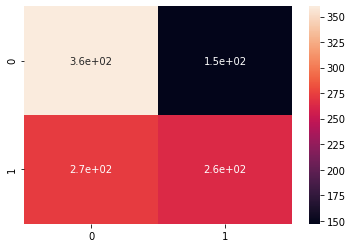

In [121]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(rbf_kernel(X))

pred = clustering.labels_
df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True)
plt.show()